# Final Proj Step 2 : NLP and the Pipeline - Tokenize and create a VOCAB and LIB files 

* DS5001 - from the orig by Raf Alvarado and now edited by Neil McPherson - 2024 02/18, then again in April for Final proj work on sci fi novels 


# Overview

We import a collection of texts and convert to F2. Then we annotate the collection to create an F3-level model.

# Set Up

## Configs

In [1]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
epub_dir = './allBooks'  
outputDir = './outputFiles/'

In [2]:
import time
time.ctime() # 'Mon Oct 18 13:35:29 2010'

'Sat Apr 13 13:08:20 2024'

##  below you can run the nltk download() installer and see where you installed the corpora etc from nltk

In [3]:
#import nltk
#nltk.download()

In [4]:
import os
os.environ["NLTK_DATA"] = "c:/OneDrive/DS5001_Spring2024/nltk_data"
print(os.environ["NLTK_DATA"])

c:/OneDrive/DS5001_Spring2024/nltk_data


## Imports

In [5]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk

In [6]:
%matplotlib inline

## Import NLTK and download resources

If you need to install NLTK, see the [instructions here](https://www.nltk.org/install.html). You can also install this with Anaconda, like so:

`conda install nltk`

Once you have installed NLTK, you will need to download resources, which will happen when you run the following cell. If the interactive window opens, you may need to set your NLTK Data Directory, as described in the [instructions here](https://www.nltk.org/data.html). To set the directory, click on the File menu and select Change Download Directory. For central installation, set this to `C:\nltk_data` (Windows),`/usr/local/share/nltk_data` (Mac), or `/usr/share/nltk_data` (Unix). 

> If you did not install the data to one of the above central locations, you will need to set the NLTK_DATA environment variable to specify the location of the data. (On a Windows machine, right click on “My Computer” then select Properties > Advanced > Environment Variables > User Variables > New...)

In [7]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nmcph\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nmcph\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nmcph\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\nmcph\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

# Acquire

We download the novels of Jane Austen and Herman Melville from Project Gutenberg. I actually used a utility I created called PGTK:

* https://github.com/ontoligent-design/pgtk

# Inspect

Since Project Gutenberg texts vary widely in their markup, we define our chunking patterns by hand.

In [8]:
roman = '[IVXLCM.]+'
caps = "[A-Z';, -]+"
chap_pats = {
    ## this is Flatland by Edwin Abbott Abbott
    201: {  
        'start_line': 274,
        'end_line': 3849,
        'chapter': re.compile("^Section\s+\d+\..*$")
    },
    ## A Princess of Mars by Edgar Rice Burroughs
    62: {
        'start_line': 213,
        'end_line': 7130,
        'chapter': re.compile("^CHAPTER\s+{}\s*$".format(roman))
    },
    ## The Gods of Mars by Edgar Rice Burroughs
    64: {
        'start_line': 186,
        'end_line': 9319,
        'chapter': re.compile("^CHAPTER\s+{}\s*$".format(roman))
    },
    ## Beyond Lies the Wub by Philip K. Dick -- NOTE there are no real chapters but separations with asterisks - I 
    ## am going to take some license here and cut this story into chapters at the breaks- it is really a short story! 
    28554: {
        'start_line': 43,
        'end_line': 496,
        'chapter': re.compile("^CHAPTER \d\s+\*\s+\*\s+\*\s+\*.+$")
    },
    ## Second Variety by Philip K. Dick -- NOTE there are no real chapters but separations with asterisks - I 
    ## am going to take some license here and cut this story into chapters at the breaks - I introduced CHAPTER numbers into 
    ## the file here to be clear and to the one above 
    32032: {
        'start_line': 54,
        'end_line': 2611,
        'chapter': re.compile("^CHAPTER \d+\s+\*\s+\*\s+\*\s+\*.+$")
    },
    ## The Eyes have It  by Philip K. Dick -- NOTE there are no real chapters but separations with asterisks - I 
    ## am going to take some license here and cut this story into chapters at the breaks - I introduced CHAPTER numbers into 
    ## the file here to be clear and to the one above 
    31516: {
        'start_line': 55,
        'end_line': 203,
        'chapter': re.compile("^CHAPTER \d+\s+\*\s+\*\s+\*\s+\*.+$")
    },
    ## The Hanging Stranger  by Philip K. Dick -- NOTE there are no real chapters but separations with asterisks - I 
    ## am going to take some license here and cut this story into chapters at the breaks - I introduced CHAPTER numbers into 
    ## the file here to be clear and to the one above 
    41562: {
        'start_line': 57,
        'end_line': 789,
        'chapter': re.compile("^CHAPTER \d+\s+\*\s+\*\s+\*\s+\*.+$")
    },
    ## # 139 - the Lost World - Arthur C Doyle 
    139: {
        'start_line': 104,
        'end_line': 8016,
        'chapter': re.compile("^\s*CHAPTER\s+{}\s*$".format(roman))
    },
    ## # 42243 - The Hour of the Dragon  
    42243: {
        'start_line': 50,
        'end_line': 8268,
        'chapter': re.compile("^\d+\s*\s*$")
    },
    ## # 51233 - The Marching Morons  - again here I added CHAPTERs and I arbitrarily split it into 5 chaps 
    51233: {
        'start_line': 54,
        'end_line': 1565,
        'chapter': re.compile("^CHAPTER \d+\s+\*\s+\*\s+\*\s+\*.+$")
    },
    ## # 1329 - The Voyage to Arcturus
    1329: {
        'start_line': 84,
        'end_line': 12259,
        'chapter': re.compile("^Chapter\s\d+\.\s+.+$")          
    },
    ## # 29614 - THE_GAME_OF_RAT_AND_DRAGON
    29614: {
        'start_line': 73,
        'end_line': 824,
        'chapter': re.compile("^CHAPTER \d+\s+\*\s+\*\s+\*\s+\*.+$")
    },
    
    ## # 1250 - The Anthem
    1250: {
        'start_line': 59,
        'end_line': 2170,
        'chapter': re.compile("^PART\s+\w+$")          
    },
    ## # 18857 - A Journey to the Center of the Earth 
    18857: {
        'start_line': 148,
        'end_line': 10956,
        'chapter': re.compile("^CHAPTER\s+\d+$")          
    },
    ## VERNE_JULES_FROM_THE_EARTH_TO_THE_MOON_AND_ROUND_THE_MOON-pg83.txt'
    83: {
        'start_line': 102,
        'end_line': 11451,
        'chapter': re.compile("^CHAPTER\s+{}$".format(roman))      
    },
    ### VERNE_JULES_THE_MYSTERIOUS_ISLAND-pg1268.txt'
    1268: {
        'start_line': 39,
        'end_line': 23135,
        'chapter': re.compile("^Chapter\s+\d+$")      
    },
    ### VERNE_JULES_TWENTY_THOUSAND_LEAGUES_UNDER_THE_SEA-pg164.txt'
    164: {
        'start_line': 112,
        'end_line': 12454,
        'chapter': re.compile("^CHAPTER\s+{}$".format(roman))      
    },
    ### VONNEGUT_KURT_2_B_R_0_2_B-pg21279.txt
    21279: {
        'start_line': 68,
        'end_line': 454,
        'chapter': re.compile("^CHAPTER \d+\s+\*\s+\*\s+\*\s+\*.+$")      
    },
    ### VONNEGUT_KURT_THE_BIG_TRIP_UP_YONDER-pg30240.txt
    30240: {
        'start_line': 53,
        'end_line': 515,
        'chapter': re.compile("^CHAPTER \d+\s+\*\s+\*\s+\*\s+\*.+$")      
    },
    #### WEINBAUM_STANLEY_G_STANLEY_GRAUMAN_A_MARTIAN_ODYSSEY-pg23731.txt
    23731: {
        'start_line': 47,
        'end_line': 1188,
        'chapter': re.compile("^CHAPTER \d+$")      
    },
    ### WELLS_H_G_HERBERT_GEORGE_THE_COUNTRY_OF_THE_BLIND_AND_OTHER_STORIES-pg11870
    11870: {
        'start_line': 292,
        'end_line': 16755,
        'chapter': re.compile("^[IVXLCM.]+$".format(roman))      
    },
    ### WELLS_H_G_HERBERT_GEORGE_THE_ISLAND_OF_DOCTOR_MOREAU-pg159.txt
    159: {
        'start_line': 115,
        'end_line': 4730,
        'chapter': re.compile("^[IVXLCM.]+$".format(roman))      
    },
    ###  WELLS_H_G_HERBERT_GEORGE_THE_TIME_MACHINE-pg35.txt
    35: {
        'start_line': 56,
        'end_line': 3202,
        'chapter': re.compile("^[IVXLCM.]+$".format(roman))      
    },
    ### WELLS_H_G_HERBERT_GEORGE_THE_WAR_OF_THE_WORLDS-pg36.txt
    36: {
        'start_line': 88,
        'end_line': 6400,
        'chapter': re.compile("^[IVXLCM.]+$".format(roman))      
    },
    ### Hodgson - Hope the night land 
    10662: {
        'start_line': 64,
        'end_line': 17440,
        'chapter': re.compile("^[IVXLCM.]+$".format(roman))      
    }
}

# Register and Chunk

In [9]:
def acquire_epubs(epub_list, chap_pats, OHCO=OHCO):
    
    my_lib = []
    my_doc = []

    for epub_file in epub_list:
        
        # Get Book ID and author from filename
        book_id = int(epub_file.split('-')[-1].split('.')[0].replace('pg',''))
        print("BOOK ID", book_id)
        
        author = epub_file.split('_')[0]
        author = author.split('\\')[1]
        #print("author is ", author)
    
        # Import file as lines
        lines = open(epub_file, 'r', encoding='utf-8-sig').readlines()
        df = pd.DataFrame(lines, columns=['line_str'])
        #print("just did the pd.dataframe")
        #print(df)
        df.index.name = 'line_num'
        df.line_str = df.line_str.str.strip()
        df['book_id'] = book_id
        
        # FIX CHARACTERS TO IMPROVE TOKENIZATION
        df.line_str = df.line_str.str.replace('—', ' — ', regex=True)
        df.line_str = df.line_str.str.replace('-', ' - ', regex=True)
        
        # Get book title and put into LIB table -- note problems, though
        book_title = re.sub(r"The Project Gutenberg eBook( of|,) ", "", df.loc[0].line_str, flags=re.IGNORECASE)
        book_title = re.sub(r"Project Gutenberg's ", "", book_title, flags=re.IGNORECASE)
        
        # Remove cruft
        a = chap_pats[book_id]['start_line'] - 1
        b = chap_pats[book_id]['end_line'] + 1
        df = df.iloc[a:b]
        
        #print("just did the cruft remove ")
        #print(df)
        #df.to_csv("MyDF", sep = "|")
        
        # Chunk by chapter
        chap_lines = df.line_str.str.match(chap_pats[book_id]['chapter'])
        chap_nums = [i+1 for i in range(df.loc[chap_lines].shape[0])]
        #print("chap_nums is ", chap_nums)
        df.loc[chap_lines, 'chap_num'] = chap_nums
        df.chap_num = df.chap_num.ffill()

        # Clean up
        df = df[~df.chap_num.isna()] # Remove chapter heading lines
        df = df.loc[~chap_lines] # Remove everything before Chapter 1
        df['chap_num'] = df['chap_num'].astype('int')
        
        # Group -- Note that we exclude the book level in the OHCO at this point
        df = df.groupby(OHCO[1:2]).line_str.apply(lambda x: '\n'.join(x)).to_frame() # Make big string
        
        # Split into paragrpahs
        df = df['line_str'].str.split(r'\n\n+', expand=True).stack().to_frame().rename(columns={0:'para_str'})
        df.index.names = OHCO[1:3] # MAY NOT BE NECESSARY UNTIL THE END
        #print(df)
        df['para_str'] = df['para_str'].str.replace(r'\n', ' ', regex=True).str.strip()
        df = df[~df['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs
       
        # Set index
        df['book_id'] = book_id
        df = df.reset_index().set_index(OHCO[:3])

        # Register
        my_lib.append((book_id, book_title, author, epub_file))
        my_doc.append(df)

    docs = pd.concat(my_doc)
    library = pd.DataFrame(my_lib, columns=['book_id', 'book_title', 'author', 'book_file']).set_index('book_id')
    return library, docs

In [10]:
glob(epub_dir+'/*.txt')

['./allBooks\\ABBOTT_EDWIN_ABBOTT_FLATLAND_A_ROMANCE_OF_MANY_DIMENSIONS-pg201.txt',
 './allBooks\\BURROUGHS_EDGAR_RICE_A_PRINCESS_OF_MARS-pg62.txt',
 './allBooks\\BURROUGHS_EDGAR_RICE_THE_GODS_OF_MARS-pg64.txt',
 './allBooks\\DICK_PHILIP_K_BEYOND_LIES_THE_WUB-pg28554.txt',
 './allBooks\\DICK_PHILIP_K_SECOND_VARIETY-pg32032.txt',
 './allBooks\\DICK_PHILIP_K_THE_EYES_HAVE_IT-pg31516.txt',
 './allBooks\\DICK_PHILIP_K_THE_HANGING_STRANGER-pg41562.txt',
 './allBooks\\DOYLE_ARTHUR_CONAN_THE_LOST_WORLD-pg139.txt',
 './allBooks\\HODGSON_WILLIAM_HOPE_THE_NIGHT_LAND-pg10662.txt',
 './allBooks\\HOWARD_ROBERT_E_ROBERT_ERVIN_THE_HOUR_OF_THE_DRAGON-pg42243.txt',
 './allBooks\\KORNBLUTH_C_M_CYRIL_M_THE_MARCHING_MORONS-pg51233.txt',
 './allBooks\\LINDSAY_DAVID_A_VOYAGE_TO_ARCTURUS-pg1329.txt',
 './allBooks\\LINEBARGER_PAUL_MYRON_ANTHONY_THE_GAME_OF_RAT_AND_DRAGON-pg29614.txt',
 './allBooks\\RAND_AYN_ANTHEM-pg1250.txt',
 './allBooks\\VERNE_JULES_A_JOURNEY_TO_THE_CENTRE_OF_THE_EARTH-pg18857.txt',
 './al

In [11]:
epub_dir

'./allBooks'

In [12]:
#glob('../pgtk_util/pgtk/mybooks/*62.txt')

In [13]:
epubs = [epub for epub in sorted(glob(epub_dir+'/*pg*.txt'))]

In [14]:
LIB, DOC = acquire_epubs(epubs, chap_pats)

BOOK ID 201
BOOK ID 62
BOOK ID 64
BOOK ID 28554
BOOK ID 32032
BOOK ID 31516
BOOK ID 41562
BOOK ID 139
BOOK ID 10662
BOOK ID 42243
BOOK ID 51233
BOOK ID 1329
BOOK ID 29614
BOOK ID 1250
BOOK ID 18857
BOOK ID 83
BOOK ID 1268
BOOK ID 164
BOOK ID 21279
BOOK ID 30240
BOOK ID 23731
BOOK ID 11870
BOOK ID 159
BOOK ID 35
BOOK ID 36


In [15]:
epubs

['./allBooks\\ABBOTT_EDWIN_ABBOTT_FLATLAND_A_ROMANCE_OF_MANY_DIMENSIONS-pg201.txt',
 './allBooks\\BURROUGHS_EDGAR_RICE_A_PRINCESS_OF_MARS-pg62.txt',
 './allBooks\\BURROUGHS_EDGAR_RICE_THE_GODS_OF_MARS-pg64.txt',
 './allBooks\\DICK_PHILIP_K_BEYOND_LIES_THE_WUB-pg28554.txt',
 './allBooks\\DICK_PHILIP_K_SECOND_VARIETY-pg32032.txt',
 './allBooks\\DICK_PHILIP_K_THE_EYES_HAVE_IT-pg31516.txt',
 './allBooks\\DICK_PHILIP_K_THE_HANGING_STRANGER-pg41562.txt',
 './allBooks\\DOYLE_ARTHUR_CONAN_THE_LOST_WORLD-pg139.txt',
 './allBooks\\HODGSON_WILLIAM_HOPE_THE_NIGHT_LAND-pg10662.txt',
 './allBooks\\HOWARD_ROBERT_E_ROBERT_ERVIN_THE_HOUR_OF_THE_DRAGON-pg42243.txt',
 './allBooks\\KORNBLUTH_C_M_CYRIL_M_THE_MARCHING_MORONS-pg51233.txt',
 './allBooks\\LINDSAY_DAVID_A_VOYAGE_TO_ARCTURUS-pg1329.txt',
 './allBooks\\LINEBARGER_PAUL_MYRON_ANTHONY_THE_GAME_OF_RAT_AND_DRAGON-pg29614.txt',
 './allBooks\\RAND_AYN_ANTHEM-pg1250.txt',
 './allBooks\\VERNE_JULES_A_JOURNEY_TO_THE_CENTRE_OF_THE_EARTH-pg18857.txt',
 './al

In [16]:
DOC.sample(10)

para_str
book_id chap_num para_num                                                   
1268    29       33        The field was prepared, then surrounded with a...
18857   36       32        A quarter of an hour later we were far away fr...
1329    12       176       “You will get nearer to him tomorrow; but not ...
        14       126       Maskull kept his eyes fixed on him, but made n...
11870   49       13        But Holroyd was thinking that these little cre...
1268    42       89                                              “A vessel!”
42243   22       53        'He was not a living man,' she said. 'The Hear...
        21       26        'But while we wait,' protested Amalric, 'Conan...
18857   22       53        "Perfectly," said I, for I had quite made up m...
164     17       18        Nearly every day, for some time, the panels of...

# Tokenize and Annotate

We use NLTK this time. Note that this process takes some time, mainly because the NLTK functions are not optimized for dataframes.

In [17]:
def tokenize(doc_df, OHCO=OHCO, remove_pos_tuple=False, ws=False):
    
    # Paragraphs to Sentences
    df = doc_df.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    
    # Sentences to Tokens
    # Local function to pick tokenizer
    def word_tokenize(x):
        if ws:
            s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
        else:
            s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x)))
        return s
            
    df = df.sent_str\
        .apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    
    # Grab info from tuple
    df['pos'] = df.pos_tuple.apply(lambda x: x[1])
    df['token_str'] = df.pos_tuple.apply(lambda x: x[0])
    if remove_pos_tuple:
        df = df.drop('pos_tuple', 1)
    
    # Add index
    df.index.names = OHCO
    
    return df

In [18]:
%time TOKEN = tokenize(DOC, ws=True)

Wall time: 2min 47s


In [19]:
TOKEN.head()

pos_tuple   pos  \
book_id chap_num para_num sent_num token_num                           
201     1        1        0        0                  (I, PRP)   PRP   
                                   1               (call, VBP)   VBP   
                                   2               (our, PRP$)  PRP$   
                                   3               (world, NN)    NN   
                                   4          (Flatland,, NNP)   NNP   

                                              token_str  
book_id chap_num para_num sent_num token_num             
201     1        1        0        0                  I  
                                   1               call  
                                   2                our  
                                   3              world  
                                   4          Flatland,

In [20]:
TOKEN[TOKEN.pos.str.match('^JJ')]

pos_tuple  pos  token_str
book_id chap_num para_num sent_num token_num                                  
201     1        1        0        20              (happy, JJ)   JJ      happy
                 2        0        2                (vast, JJ)   JJ       vast
                                   15              (other, JJ)   JJ      other
                                   16           (figures,, JJ)   JJ   figures,
                                   42                (it,, JJ)   JJ        it,
...                                                        ...  ...        ...
36      27       12       1        100           (silent,, JJ)   JJ    silent,
                                   106              (last, JJ)   JJ       last
                                   107             (great, JJ)   JJ      great
                 13       0        1          (strangest, JJS)  JJS  strangest
                                   9              (wife’s, JJ)   JJ     wife’s

[105749 rows x 3 columns]

# Reduce

Extract a vocabulary from the TOKEN table

In [21]:
TOKEN['term_str'] = TOKEN['token_str'].str.lower().str.replace('[\W_]', '', regex=True)

In [22]:
VOCAB = TOKEN.term_str.value_counts().to_frame().rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
VOCAB.index.name = 'term_id'

In [23]:
VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')

In [24]:
VOCAB

,term_str,n,num
term_id,,,
0,,19360,0
1,0,18,1
2,000436,1,1
3,0009,9,1
4,03,1,1
...,...,...,...
31565,zostera,2,0
31566,zouaves,1,0
31567,à,5,0


# Annotate (VOCAB)

## Add Stopwords

We use NLTK's built in stopword list for English. Note that we can add and subtract from this list, or just create our own list and keep it in our data model.

In [25]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [26]:
sw.sample(10)

,dummy
term_str,
such,1
your,1
by,1
than,1
few,1
s,1
herself,1
am,1
myself,1


In [27]:
VOCAB['stop'] = VOCAB.term_str.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [28]:
VOCAB[VOCAB.stop == 1].sample(10)

,term_str,n,num,stop
term_id,,,,
27925,theirs,32,0,1
14911,into,3536,0,1
19265,or,3340,0,1
27927,them,3714,0,1
995,again,1835,0,1
19402,out,3277,0,1
24814,she,3899,0,1
8390,do,2446,0,1
22384,re,58,0,1


## Add Stems

In [29]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
VOCAB['p_stem'] = VOCAB.term_str.apply(stemmer.stem)

In [30]:
VOCAB.sample(10)

,term_str,n,num,stop,p_stem
term_id,,,,,
3323,bluntly,2,0,0,bluntli
6528,cragsman,1,0,0,cragsman
24393,seals,26,0,0,seal
17775,mistakes,3,0,0,mistak
30316,vitiated,5,0,0,vitiat
21406,previously,36,0,0,previous
4536,ccdrmi,1,0,0,ccdrmi
11645,gamblers,1,0,0,gambler
10562,fetter,2,0,0,fetter


## Add pos_max

In [31]:
LIB

,book_title,author,book_file
book_id,,,
201,Flatland: A Romance of Many Dimensions,ABBOTT,./allBooks\ABBOTT_EDWIN_ABBOTT_FLATLAND_A_ROMA...
62,A Princess of Mars,BURROUGHS,./allBooks\BURROUGHS_EDGAR_RICE_A_PRINCESS_OF_...
64,The Gods of Mars,BURROUGHS,./allBooks\BURROUGHS_EDGAR_RICE_THE_GODS_OF_MA...
28554,Beyond Lies the Wub,DICK,./allBooks\DICK_PHILIP_K_BEYOND_LIES_THE_WUB-p...
32032,Second Variety,DICK,./allBooks\DICK_PHILIP_K_SECOND_VARIETY-pg3203...
31516,The Eyes Have It,DICK,./allBooks\DICK_PHILIP_K_THE_EYES_HAVE_IT-pg31...
41562,The Hanging Stranger,DICK,./allBooks\DICK_PHILIP_K_THE_HANGING_STRANGER-...
139,The Lost World,DOYLE,./allBooks\DOYLE_ARTHUR_CONAN_THE_LOST_WORLD-p...
10662,The Night Land,HODGSON,./allBooks\HODGSON_WILLIAM_HOPE_THE_NIGHT_LAND...


In [32]:
time.ctime() # 'Mon Oct 18 13:35:29 2010'

'Sat Apr 13 13:11:15 2024'

# Save

In [33]:
DOC.to_csv(outputDir+'DOC.csv')
LIB.to_csv(outputDir+'LIB2.csv')
VOCAB.to_csv(outputDir+'VOCAB.csv')
TOKEN.to_csv(outputDir+'TOKEN.csv')

In [34]:
print("All done writing files")

All done writing files


In [35]:
time.ctime() # 'Mon Oct 18 13:35:29 2010'

'Sat Apr 13 13:11:22 2024'

# Save to SQLite

In [36]:
#import sqlite3

#TOKEN = TOKEN.drop('pos_tuple', 1)

#with sqlite3.connect('mod4-corpus.db') as db:
#    DOC.to_sql('doc', db, index=True, if_exists='replace')
#    LIB.to_sql('lib', db, index=True, if_exists='replace')
#    VOCAB.to_sql('vocab', db, index=True, if_exists='replace')
#    TOKEN.to_sql('token', db, index=True, if_exists='replace')

# Appendix: Explore NER tagging

In [37]:
%time NER = TOKEN.groupby(OHCO[:4]).pos_tuple.apply(lambda x: nltk.ne_chunk(x.tolist())).to_frame().rename(columns={'pos_tuple':'nltk_sentence'})

Wall time: 6min 55s


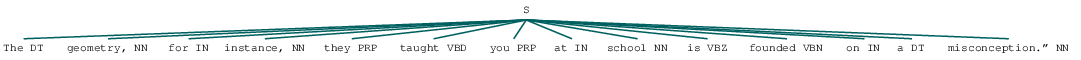

In [38]:
NER.iloc[8].values[0]

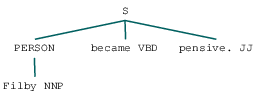

In [39]:
NER.iloc[26].values[0]

# POS Tagset

This a token-level feature -- not a vocab feature

In [40]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [41]:
pd.__version__

'1.4.4'